In [23]:
library(Seurat)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(dplyr)
library(DESeq2)
library(dplyr)
library(ggrepel)
library(patchwork)
library(viridis)
library(EnhancedVolcano)
library(pheatmap)
library(clusterProfiler)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object i

In [2]:
sce <- readRDS('after_single.rds')
gene_signature_config <- list(
  DP_DPlike = c("Rspo3", "Prlr", "Bmp4", "Bmp7", "Trps1"),
  pathway_name = "Dermal Papilla Signature",
  analysis_type = "marker_expression"
)

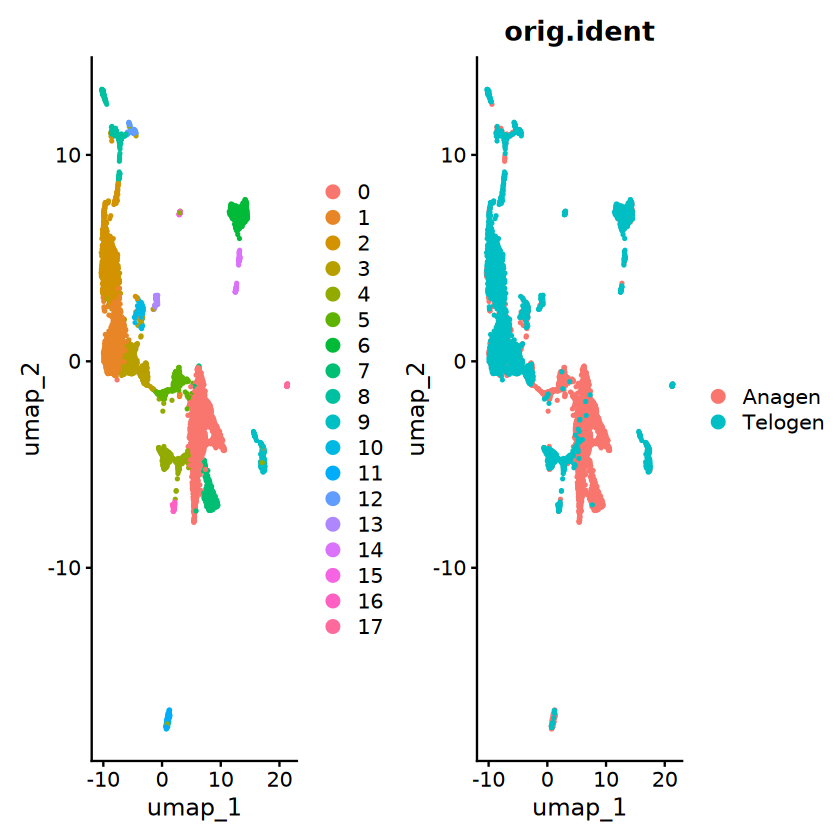

In [11]:
DimPlot(sce)|DimPlot(sce,group.by = 'orig.ident')

In [6]:
create_enhanced_dotplot <- function(seurat_obj, 
                                  gene_list, 
                                  group_by = NULL,
                                  title = NULL,
                                  color_palette = "viridis",
                                  size_range = c(1, 8)) {
  
  # 验证基因存在性
  available_genes <- intersect(gene_list, rownames(seurat_obj))
  missing_genes <- setdiff(gene_list, available_genes)
  
  if(length(missing_genes) > 0) {
    warning("Missing genes: ", paste(missing_genes, collapse = ", "))
  }
  
  cat("📊 Creating enhanced DotPlot for", length(available_genes), "genes\n")
  
  # 基础DotPlot
  p <- DotPlot(seurat_obj, 
               features = available_genes,
               assay = 'RNA',
               group.by = group_by,
               scale = TRUE) +  # 标准化表达量
    
    # 主题美化
    theme_minimal() +
    theme(
      # 坐标轴
      axis.text.x = element_text(
        angle = 45, 
        hjust = 1, 
        vjust = 1,
        size = 11,
        face = "italic"  # 基因名斜体
      ),
      axis.text.y = element_text(size = 11, face = "bold"),
      
      # 面板设置
      panel.grid.major = element_line(color = "grey90", size = 0.2),
      panel.grid.minor = element_blank(),
      panel.border = element_rect(color = "black", fill = NA, size = 0.5),
      
      # 图例
      legend.position = "right",
      legend.title = element_text(size = 10, face = "bold"),
      legend.text = element_text(size = 9),
      legend.box = "vertical",
      
      # 标题
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 11, hjust = 0.5, color = "grey40")
    ) +
    
    # 坐标轴标签
    labs(
      x = "Gene Markers",
      y = "Cell Types",
      title = title %||% "Expression Pattern Analysis",
      subtitle = paste("n =", length(available_genes), "genes")
    ) +
    
    # 图例标题
    guides(
      size = guide_legend(
        title = "% Expression",
        override.aes = list(color = "black"),
        title.position = "top"
      ),
      color = guide_colorbar(
        title = "Avg Expression\n(scaled)",
        title.position = "top",
        barwidth = 1,
        barheight = 6
      )
    )
  
  # 颜色配置
  if(color_palette == "viridis") {
    p <- p + scale_color_viridis_c(option = "plasma", direction = 1)
  } else if(color_palette == "custom") {
    p <- p + scale_color_gradientn(
      colours = c('#330066', '#336699', '#66CC66', '#FFCC33') ,
      name = "Scaled\nExpression"
    )
  } else if(color_palette == "academic") {
    p <- p + scale_color_gradient2(
      low = "#313695", 
      mid = "white", 
      high = "#D73027",
      midpoint = 0,
      name = "Scaled\nExpression"
    )
  }
  
  # 点大小范围
  p <- p + scale_size_continuous(range = size_range)
  
  return(p)
}

In [7]:
# 创建增强版DotPlot
enhanced_plot <- create_enhanced_dotplot(
  seurat_obj = sce,
  gene_list = gene_signature_config$DP_DPlike,
  title = gene_signature_config$pathway_name,
  color_palette = "custom",
  size_range = c(2, 10)
)

📊 Creating enhanced DotPlot for 5 genes


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


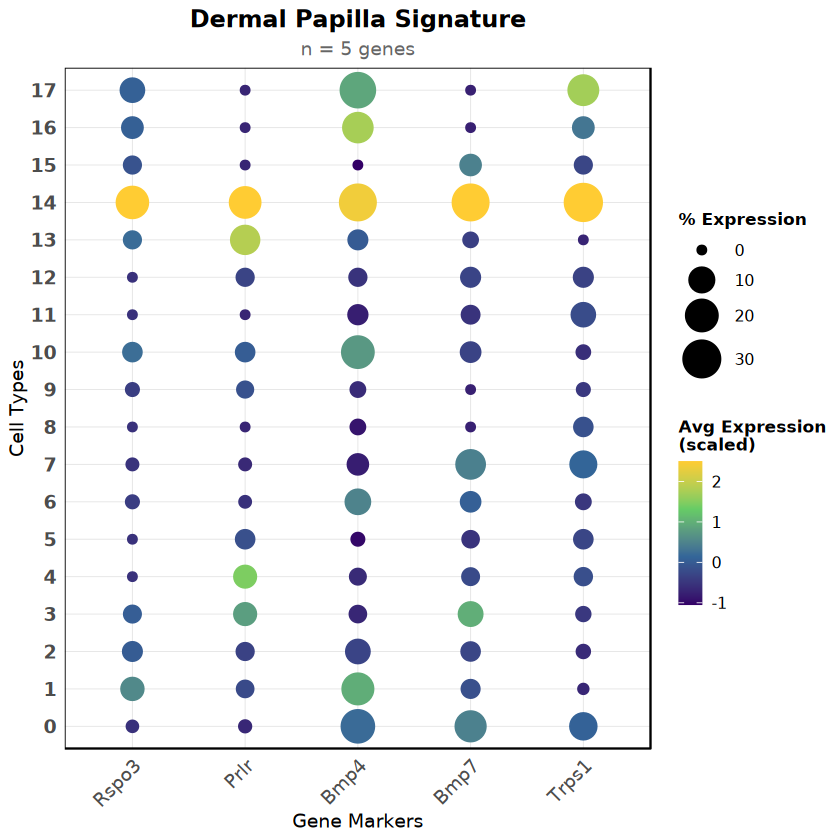

In [8]:
print(enhanced_plot)

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The following requested variables were not found: Bmp5”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


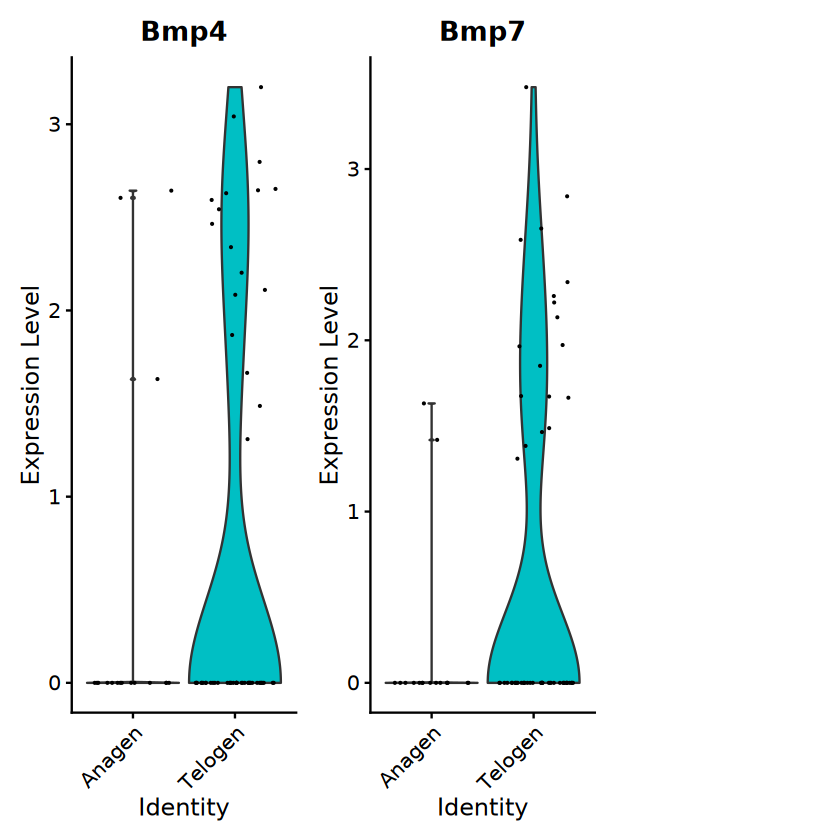

In [12]:
filter_sce = subset(sce, RNA_snn_res.0.2 %in% c(14)) 
VlnPlot(filter_sce, features = c('Bmp4','Bmp7','Bmp5'),group.by = 'orig.ident')

In [13]:
DifferentialAnalysisConfig <- R6::R6Class(
  "DifferentialAnalysisConfig",
  public = list(
    seurat_object = NULL,
    comparison_groups = list(),
    analysis_parameters = list(),
    results_storage = list(),
    
    initialize = function(seurat_obj) {
      self$seurat_object <- seurat_obj
      self$setup_default_parameters()
      cat("🔬 DEG Analysis Pipeline Initialized\n")
    },
    
    setup_default_parameters = function() {
      self$analysis_parameters <- list(
        test_method = "DESeq2",
        slot_type = "counts",
        p_threshold = 0.05,
        fc_threshold = 1,
        pct_threshold = 0.75,
        verbose_mode = FALSE
      )
    }
  )
)

In [14]:
deg_analyzer <- DifferentialAnalysisConfig$new(filter_sce)

🔬 DEG Analysis Pipeline Initialized


In [46]:
execute_comprehensive_deg_analysis <- function(seurat_obj, 
                                              group_var = "orig.ident",
                                              comparison_pairs = list(c("Anagen", "Telogen")),
                                              analysis_name = "stage_comparison") {
  
  cat("🚀 Starting Comprehensive DEG Analysis...\n")
  cat("📊 Dataset Info:", ncol(seurat_obj), "cells,", nrow(seurat_obj), "genes\n")
  
  # 动态设置身份
  original_idents <- Idents(seurat_obj)
  Idents(seurat_obj) <- group_var
  
  # 差异分析结果容器
  comprehensive_results <- list(
    raw_results = data.frame(),
    processed_results = data.frame(),
    statistics = list(),
    metadata = list(
      analysis_date = Sys.time(),
      parameters = list(
        group_variable = group_var,
        comparisons = comparison_pairs,
        analysis_name = analysis_name
      )
    )
  )
  
  # 执行批量差异分析
  for (i in seq_along(comparison_pairs)) {
    pair <- comparison_pairs[[i]]
    id1 <- pair[1]
    id2 <- pair[2]
    
    cat("🔍 Processing comparison:", id1, "vs", id2, "\n")
    
    # 细胞数量验证
    n_cells_1 <- sum(Idents(seurat_obj) == id1)
    n_cells_2 <- sum(Idents(seurat_obj) == id2)
    
    cat("   Cell counts - ", id1, ":", n_cells_1, ", ", id2, ":", n_cells_2, "\n")
    
    if (n_cells_1 < 10 || n_cells_2 < 10) {
      warning("Insufficient cells for robust analysis in comparison ", i)
      next
    }
    
    # 执行差异表达分析
    tryCatch({
      deg_results <- FindMarkers(
        seurat_obj, 
        ident.1 = id1, 
        ident.2 = id2, 
        slot = "counts",
        test.use = "DESeq2", 
        verbose = FALSE,
        min.pct = 0.75,  # 最小表达百分比
        logfc.threshold = 1  # 最小fold change阈值
      )
      
      # 数据增强处理
      deg_results$gene <- rownames(deg_results)
      deg_results$comparison <- paste0(id1, " vs ", id2)
      deg_results$comparison_id <- i
      deg_results$abs_log2FC <- abs(deg_results$avg_log2FC)
      deg_results$log10_pval <- -log10(deg_results$p_val)
      deg_results$rank_score <- deg_results$abs_log2FC * deg_results$log10_pval
      
      # 添加到综合结果
      comprehensive_results$raw_results <- rbind(comprehensive_results$raw_results, deg_results)
      
      cat("   ✅ Found", nrow(deg_results), "tested genes\n")
      
    }, error = function(e) {
      cat("   ❌ Error in comparison", i, ":", e$message, "\n")
    })
  }
  
  # 恢复原始身份
  Idents(seurat_obj) <- original_idents
  
  return(comprehensive_results)
}

# 执行分析
cat("🔬 Executing Comprehensive Analysis Pipeline...\n")
sub <- filter_sce
comprehensive_deg_results <- execute_comprehensive_deg_analysis(
  seurat_obj = sub,
  group_var = "orig.ident",
  comparison_pairs = list(c("Anagen", "Telogen")),
  analysis_name = "hair_cycle_analysis"
)


🔬 Executing Comprehensive Analysis Pipeline...
🚀 Starting Comprehensive DEG Analysis...
📊 Dataset Info: 72 cells, 15363 genes
🔍 Processing comparison: Anagen vs Telogen 
   Cell counts -  Anagen : 17 ,  Telogen : 55 


converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



   ✅ Found 209 tested genes


In [47]:
process_deg_results_advanced <- function(raw_results, 
                                        p_threshold = 0.01,
                                        fc_threshold = 1,
                                        pct_threshold = 0.75) {
  
  cat("📈 Processing DEG Results with Advanced Metrics...\n")
  
  processed_data <- raw_results %>%
    mutate(
      # 基础分类
      basic_labels = case_when(
        p_val < p_threshold & abs(avg_log2FC) > fc_threshold & pct.1 > pct_threshold & avg_log2FC > 0 ~ 'sigUp',
        p_val < p_threshold & abs(avg_log2FC) > fc_threshold & pct.1 > pct_threshold & avg_log2FC < 0 ~ 'sigDown',
        TRUE ~ 'noSig'
      ),
      
      # 增强分类系统
      enhanced_labels = case_when(
        p_val < 0.001 & abs(avg_log2FC) > 2 ~ 'Highly_Significant',
        p_val < 0.01 & abs(avg_log2FC) > 1.5 ~ 'Very_Significant', 
        p_val < 0.05 & abs(avg_log2FC) > 1 ~ 'Significant',
        p_val < 0.05 & abs(avg_log2FC) > 0.5 ~ 'Moderately_Significant',
        TRUE ~ 'Not_Significant'
      ),
      
      # 透明度映射
      point_alpha = case_when(
        basic_labels == 'sigUp' ~ 0.8,
        basic_labels == 'sigDown' ~ 0.8,
        TRUE ~ 0.3
      ),
      
      # 点大小映射
      point_size = pmin(pmax(abs(avg_log2FC) * 2, 1), 6),
      
      # 重要性评分
      importance_score = abs(avg_log2FC) * (-log10(p_val)) * (pct.1/100)
    ) %>%
    arrange(desc(importance_score))
  
  # 统计摘要
  summary_stats <- list(
    total_genes = nrow(processed_data),
    significant_up = sum(processed_data$basic_labels == 'sigUp'),
    significant_down = sum(processed_data$basic_labels == 'sigDown'),
    not_significant = sum(processed_data$basic_labels == 'noSig'),
    highly_significant = sum(processed_data$enhanced_labels == 'Highly_Significant'),
    mean_log2fc = mean(abs(processed_data$avg_log2FC)),
    median_pval = median(processed_data$p_val)
  )
  
  cat("📊 Analysis Summary:\n")
  cat("   Total genes tested:", summary_stats$total_genes, "\n")
  cat("   Significantly upregulated:", summary_stats$significant_up, "\n")
  cat("   Significantly downregulated:", summary_stats$significant_down, "\n")
  cat("   Highly significant:", summary_stats$highly_significant, "\n")
  
  return(list(data = processed_data, stats = summary_stats))
}


In [48]:
processed_results <- process_deg_results_advanced(comprehensive_deg_results$raw_results)
deg_temp <- processed_results$data

📈 Processing DEG Results with Advanced Metrics...
📊 Analysis Summary:
   Total genes tested: 209 
   Significantly upregulated: 26 
   Significantly downregulated: 2 
   Highly significant: 7 


In [49]:
select_genes_for_labeling <- function(deg_data, n_top = 10, criteria = "importance") {
  
  if (criteria == "importance") {
    top_genes <- deg_data %>%
      filter(basic_labels != 'noSig') %>%
      slice_max(order_by = importance_score, n = n_top) %>%
      pull(gene)
  } else if (criteria == "fold_change") {
    top_genes <- deg_data %>%
      filter(basic_labels != 'noSig') %>%
      slice_max(order_by = abs(avg_log2FC), n = n_top) %>%
      pull(gene)
  } else {
    top_genes <- deg_data %>%
      filter(basic_labels != 'noSig') %>%
      slice_min(order_by = p_val, n = n_top) %>%
      pull(gene)
  }
  
  return(top_genes)
}


In [54]:
# 动态选择标注基因
genes_to_label <- select_genes_for_labeling(deg_temp, n_top = 30, criteria = "importance")

# 增强型火山图生成器  
create_enhanced_volcano_plot <- function(deg_data, 
                                       genes_to_label,
                                       title = "Enhanced Volcano Plot",
                                       coordinate_limits = list(x = c(-3, 3), y = c(0, 5))) {
  
  cat("🌋 Creating Enhanced Volcano Plot...\n")
  
  # 主要火山图
  volcano_plot <- ggplot(deg_data, aes(x = avg_log2FC, y = -log10(p_val))) +
    
    # 背景参考线
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "grey60", alpha = 0.7) +
    geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey60", alpha = 0.7) +
    
    # 散点图 - 使用动态大小和透明度
    geom_point(aes(fill = basic_labels, 
                   alpha = point_alpha,
                   size = point_size),
               shape = 21, 
               stroke = 0.1) +
    
    # 基因标注
    geom_text_repel(
      data = subset(deg_data, gene %in% genes_to_label),
      aes(label = gene),
      size = 4,  
      box.padding = unit(0.5, "lines"),
      point.padding = unit(0.5, "lines"),
      segment.color = "gray40",
      segment.size = 0.5,
      max.overlaps = Inf,
      show.legend = FALSE,
      fontface = "italic"
    ) +
    
    # 颜色和大小映射
    scale_fill_manual(
      values = c("sigUp" = "#E74C3C", "sigDown" = "#3498DB", "noSig" = "#BDC3C7"),
      name = "Expression\nChange"
    ) +
    scale_alpha_identity() +
    scale_size_identity() +
    
    # 坐标轴设置
    scale_x_continuous(
      limits = coordinate_limits$x,
      breaks = seq(-3, 3, 1)
    ) +
    scale_y_continuous(
      limits = coordinate_limits$y,
      expand = c(0.02, 0)
    ) +
    
    # 标签和主题
    labs(
      x = expression(Log[2]~"Fold Change"),
      y = expression(-Log[10]~"(P-value)"),
      title = title,
      subtitle = paste("Significant genes:", 
                      sum(deg_data$basic_labels != 'noSig'),
                      "| Total tested:", nrow(deg_data))
    ) +
    
    # 高级主题
    theme_minimal(base_size = 12) +
    theme(
      panel.grid.major = element_line(color = "grey90", size = 0.3),
      panel.grid.minor = element_blank(),
      panel.border = element_rect(color = "black", fill = NA, size = 0.5),
      
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 11, hjust = 0.5, color = "grey40"),
      
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      
      legend.position = "right",
      legend.title = element_text(size = 10, face = "bold"),
      legend.text = element_text(size = 9),
      legend.box.background = element_rect(color = "grey80", fill = "white"),
      
      plot.margin = margin(t = 20, r = 20, b = 20, l = 20)
    ) 
  
  return(volcano_plot)
}


In [55]:
enhanced_volcano <- create_enhanced_volcano_plot(
  deg_data = deg_temp,
  genes_to_label = genes_to_label,
  title = "Hair Cycle Stage Comparison: Anagen vs Telogen",
  coordinate_limits = list(x = c(-3, 3), y = c(0, 5))
)

🌋 Creating Enhanced Volcano Plot...


Warning message:
“Removed 21 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


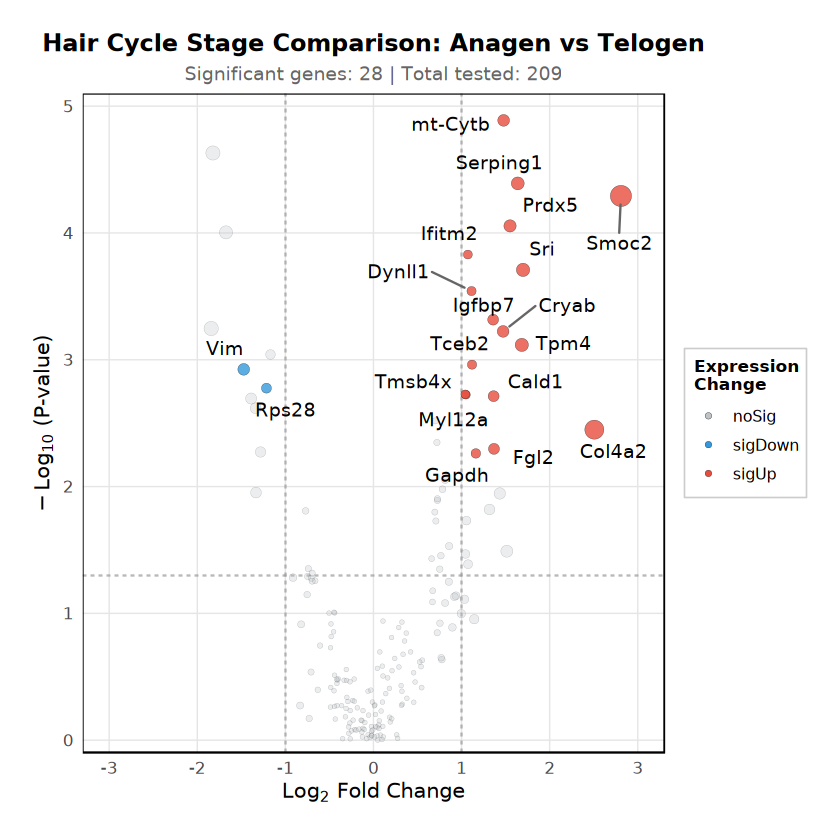

In [56]:
print(enhanced_volcano)

In [ ]:
# 高级结果处理器

# 处理结果


# 智能基因标注选择器


# 生成最终的增强火山图


# 显示图形

# 生成补充分析图表
supplementary_plots <- list(
  
  # Top基因表达热图
  top_genes_heatmap = {
    top_20_genes <- deg_temp %>%
      filter(basic_labels != 'noSig') %>%
      slice_max(order_by = importance_score, n = 20) %>%
      pull(gene)
    
    if(length(top_20_genes) > 0) {
      DoHeatmap(sub, features = top_20_genes, group.by = "orig.ident") +
        scale_fill_gradient2(low = "blue", mid = "white", high = "red") +
        theme(axis.text.y = element_text(size = 8))
    }
  },
  
  # 统计摘要图
  summary_barplot = {
    summary_data <- data.frame(
      Category = c("Up-regulated", "Down-regulated", "Not significant"),
      Count = c(
        sum(deg_temp$basic_labels == 'sigUp'),
        sum(deg_temp$basic_labels == 'sigDown'), 
        sum(deg_temp$basic_labels == 'noSig')
      )
    )
    
    ggplot(summary_data, aes(x = Category, y = Count, fill = Category)) +
      geom_col(alpha = 0.8) +
      scale_fill_manual(values = c("#E74C3C", "#3498DB", "#BDC3C7")) +
      theme_minimal() +
      theme(legend.position = "none") +
      labs(title = "DEG Summary Statistics", y = "Number of Genes")
  }
)

# 展示补充图表
if(!is.null(supplementary_plots$top_genes_heatmap)) {
  print(supplementary_plots$top_genes_heatmap)
}
print(supplementary_plots$summary_barplot)

# 保存分析结果
save_analysis_results <- function(results, plots, output_dir = "DEG_Analysis_Results") {
  
  dir.create(output_dir, showWarnings = FALSE)
  
  # 保存数据
  write.csv(results$data, file.path(output_dir, "processed_deg_results.csv"), row.names = FALSE)
  saveRDS(results, file.path(output_dir, "complete_analysis_results.rds"))
  
  # 保存图片
  ggsave(file.path(output_dir, "enhanced_volcano_plot.pdf"), plot = enhanced_volcano, 
         width = 12, height = 8, dpi = 300)
  
  cat("💾 Results saved to:", output_dir, "\n")
  
  return(file.path(output_dir))
}

# 保存结果 
output_path <- save_analysis_results(processed_results, list(volcano = enhanced_volcano))

cat("\n🎉 Enhanced DEG Analysis Pipeline Complete!\n")
cat("📁 Results available at:", output_path, "\n")

In [ ]:
sub <- filter_sce
colnames(sub)
Idents(sub) <- "orig.ident"
id1 <- c("Anagen")
id2 <- c("Telogen")
de_Mono <- data.frame()

#循环进行两两组间差异分析，使用DESeq2方法
for (i in 1:length(id1)) {
  de_markers <- FindMarkers(sub, ident.1 = id1[i], ident.2 = id2[i], slot = "counts", 
                            test.use = "DESeq2", verbose = F) #单次循环生成de_markers差异基因表
  de_markers$gene <- rownames(de_markers) #给表添加gene列
  de_markers$stage <- paste0(id1[i]," vs ",id2[i]) #给表添加比较组别列
  de_Mono <- rbind(de_Mono,de_markers) #添加到之前的结果下面合并为一个数据框
}
deg_temp = de_Mono
deg_temp$labels = ifelse(deg_temp$p_val < 0.05 & abs(deg_temp$avg_log2FC) > 1 & deg_temp$pct.1 > 0.75 ,
                        ifelse(deg_temp$avg_log2FC > 0 , 'sigUp','sigDown'),'noSig')
library(ggplot2)
library(dplyr)
library(ggrepel)



# 火山图绘制
p <- ggplot(deg_temp, aes(x = avg_log2FC, y = -log10(p_val))) +
  # 绘制散点，使用新的透明度映射
  geom_point(aes(fill = labels, alpha = point_alpha),
             shape = 21, 
             stroke = 0.1,  # 无边界
             size = 5) +
  # 标注指定基因
  geom_text_repel(
    data = subset(deg_temp, gene %in% genes_to_label),
    aes(label = gene),
    size = 4.5,  
    box.padding = unit(0.5, "lines"),
    point.padding = unit(0.5, "lines"),
    segment.color = "gray50",
    show.legend = FALSE
  ) +
  # 设置填充色
  scale_fill_manual(values = c("sigUp" = "red", "sigDown" = "skyblue", "noSig" = "#AAAAAA")) +
  # 移除alpha的图例
  scale_alpha_identity() +
  # 坐标轴和主题设置
  labs(x = "Log2 fold change", y = "-Log10(p-value)") +
  theme_bw(base_size = 14) +
  theme(
    panel.grid = element_blank(),
    legend.position = "none"
  ) + 
  ylim(0, 5) + 
  xlim(-3, 3)

print(p)

In [ ]:
library(Seurat)
sce = readRDS('after_single.rds')
DP_DPlike = c("Rspo3", "Prlr", "Bmp4",'Bmp7','Trps1') #14
p <- DotPlot(sce, features = DP_DPlike, assay = 'RNA') +
#  coord_flip() +  # 翻转坐标轴
  theme(
    panel.grid = element_blank(),  # 去除网格线
    axis.text.x = element_text(angle = 45, hjust = 0.25, vjust = 0.25)  # 设置x轴文本角度
  ) +
  labs(x = NULL, y = NULL) +  # 移除坐标轴标签
  guides(size = guide_legend("Percent Expression")) +  # 设置图例标题
  scale_color_gradientn(
    colours = c('#330066', '#336699', '#66CC66', '#FFCC33')  # 设置颜色渐变
  )

p  # 显示图形